## Introduction

Liver cirrhosis is a type of chronic condition where the liver becomes damaged due to both biochemical and clinical factors, including the abuse of alcohol or other infections. The outcomes associated for Liver cirrhosis have historically relied on clinical and genetic data to understand the potential outcomes across patient profiles. Unsupervised learning techniques can therefore be a strong method to explore underlying patterns within varied patient data that may not be readily identified through traditional classification reporting. For this project, we will use and analyze RWD data to inspect any meaningful underlying patterns in Liver cirrhosis outcome data and examine genetic feature interactions at a more complex level.

### Data Collection and Provenance

For this project, we will use the Mayo Clinic dataset from the UCI Machine Learning Repository (1). This dataset contains information on patient records from 1974 to 1984 following the completion of a study on primary biliary cirrhosis (PBC). PBC is a form of cirrhosis that causes bile build up in liver ducts, and currently has no known cure. The dataset contains 418 records on patients who took part in a placebo-controlled trial for the D-penicillamine drug. Of those 418 patients, 312 patients fully completed the trial, while 106 patients only have some basic measurements but did not fully complete the study.
\
\
(1)*Dickson, E., Grambsch, P., Fleming, T., Fisher, L., & Langworthy, A. (1989). Cirrhosis Patient Survival Prediction [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5R02G.*
\
\
**Objective:** determine any natural or meaningful structure in Liver Cirrhosis outcomes data to further understand clinical expectancies <br>
**Task Type:** Unsupervised Learning, Clustering 

Imports

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')

### Loading the Data

The data will first be loaded to view the features we will be working with and begin the cleaning process.

In [2]:
df=pd.read_csv("cirrhosis.csv")
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [3]:
size=df.shape
numerical=df.select_dtypes(include=['number']).shape[1]
categorical=df.select_dtypes(exclude=['number']).shape[1]

print(size)
print(numerical)
print(categorical)

(418, 20)
13
7


We can confirm that the dataset includes 418 records and 20 feature names. There are also 7 categorical variables and 13 numerical variables (including continuous variables.

Data features:
* Unique identifier (ID)
* Number of days between registration and event
* Status<br>
  * C = Censored
  * CL = Liver Transplant
  * D = Death
* Drug (Either D-penicillamine or the placebo)
* Demographic Information (Age & Sex)
* Clinical Info (Ascites, Hepatomegaly, Spiders, Edema)
* Laboratory Info (Bilirubin, Chloresterol etc.)

### Cleaning the Data

Since we are aware that there 106 patients in this dataset that do not have complete measurements, we will employ specific cleaning techniques in order to preserve the sample size and avoid creating bias. We will also perform routine cleaning techniques that are necessary when inspecting and using any dataset. 
<br>
Firstly, after summarizing the columns, let's remove features we don't need:

In [4]:
df=df.drop(columns=['ID'])

The let's identify the missing values and confirm the data types are correct.

In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [6]:
null=df.isnull().sum()
print(null[null>0])

Drug             106
Ascites          106
Hepatomegaly     106
Spiders          106
Cholesterol      134
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


Now that null values have been identified, categorical versus numerical columns will be separated, and then missing values will be filled with either mean data if it is numerical (as recommended by the dataset source) or mode data if it is categorical data.

In [7]:
numerical=df.select_dtypes(include=[np.number]).columns
categorical=df.select_dtypes(exclude=[np.number]).columns
for col in numerical:
    df[col]=df[col].fillna(df[col].mean())
for col in categorical:
    df[col]=df[col].fillna(df[col].mode()[0])

In [8]:
df.isnull().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

Since our task involves clustering, we will encode categorical columns to numeric values, since clustering cannot work with text. 

In [9]:
encode=pd.get_dummies(df,drop_first=True)

In [10]:
print(encode.head())

   N_Days    Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     400  21464       14.5        261.0     2.60   156.0    1718.0  137.95   
1    4500  20617        1.1        302.0     4.14    54.0    7394.8  113.52   
2    1012  25594        1.4        176.0     3.48   210.0     516.0   96.10   
3    1925  19994        1.8        244.0     2.54    64.0    6121.8   60.63   
4    1504  13918        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  ...  Stage  Status_CL  Status_D  Drug_Placebo  \
0          172.0      190.0  ...    4.0      False      True         False   
1           88.0      221.0  ...    3.0      False     False         False   
2           55.0      151.0  ...    4.0      False      True         False   
3           92.0      183.0  ...    4.0      False      True         False   
4           72.0      136.0  ...    3.0       True     False          True   

   Sex_M  Ascites_Y  Hepatomegaly_Y  Spiders_Y  Edema_S 

The next and final step to account for clustering is to scale the data so that all variables are all on the same scale.

In [11]:
scaler=StandardScaler()
xscaled=scaler.fit_transform(encode)

### Exploratory Data Analysis (EDA)

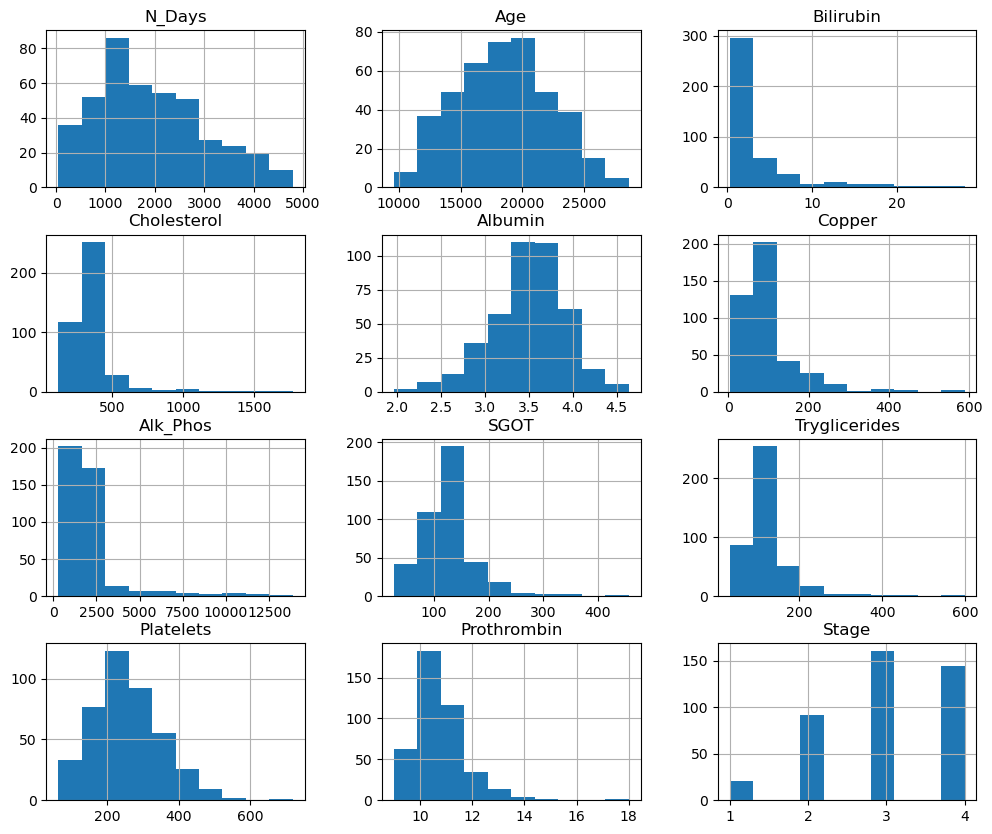

In [12]:
encode.hist(figsize=(12,10))
plt.show()

From the plots, age shows a fairly normal distribution, while variables like N_Days, Bilirubin, Prothrombin are right skewed, which could potentiall affect distance based calculations. The stage variable also shows grouped values between 1 and 4.

**Correlation Matrix**

Multicollinearity and relationships between variables can be more clearly seen with a correlation matrix.

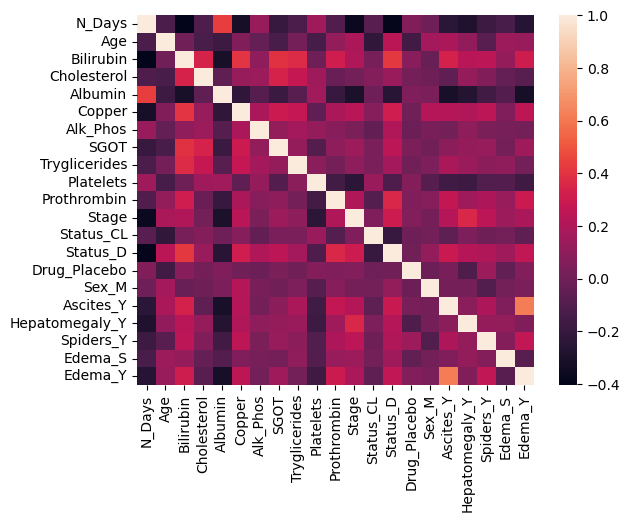

In [13]:
sns.heatmap(encode.corr())
plt.show()

What can be observed from this correlation matrix is that features which have more relationships across more features are likely to influence cluster formation in a positive way.

So far, Bilirubin and and alkaline phosphate appear to potentially be important factors for this analysis, given that both Alkaline Phosphate and Bilirubin have a strong right skew. Prothrombin and Albumin could also be features that are worth inspecting.

**Identifying Outliers**

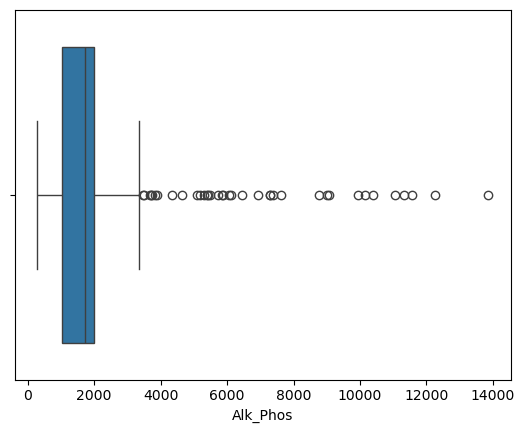

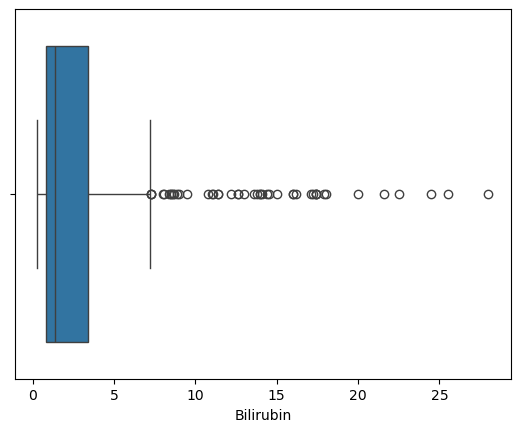

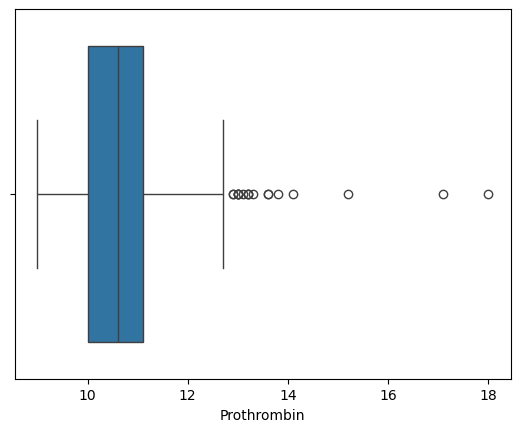

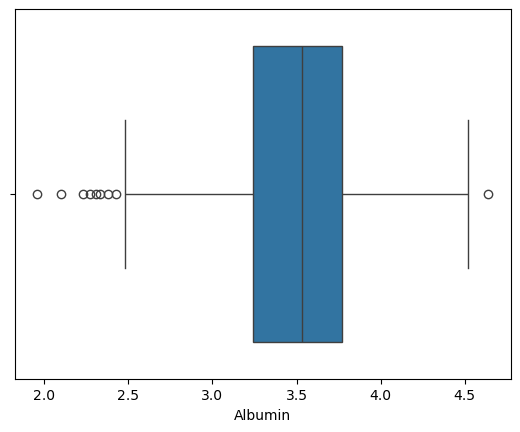

In [110]:
sns.boxplot(x=encode['Alk_Phos'])
plt.show()
sns.boxplot(x=encode['Bilirubin'])
plt.show()
sns.boxplot(x=encode['Prothrombin'])
plt.show()
sns.boxplot(x=encode['Albumin'])
plt.show()

In these boxplots, both alkaline phophatase and bilirubin showed a strong right distribution with multiple outliers, which could be attributed to patients with a more severe form of liver dysfunction.

## Performing Analysis with Unsupervised Models

After cleaning the data and exploratory analysis, unsupervised models will be used to identify groupings between patients. For this project, we will use multiple models to examine and compare which model had best examined underlying patterns in the data. KMeans will be used as a baseline model since it is able to perform well in identifying clusters within numerical data that are easy to interpret. Agglomerative clustering will also be used as a model to compare to KMeans in terms of performance because it can observe hierarchal relationships well.

**KMeans**

To determine the number of clusters we need for KMeans, we can use the elbow method and select the best K where we start to see diminishing rates in inertia (sum of square distance).

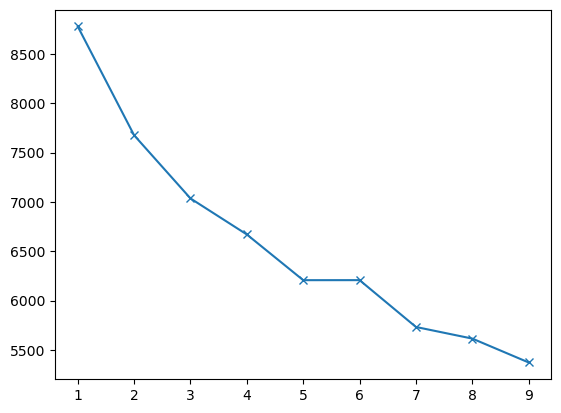

In [23]:
inertia=[]
for k in range(1,10):
    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit(xscaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,10),inertia,marker='x')
plt.show()

Based on the plot, it appears k=5 is around when the curve begins to flatten from the beginning sharp increase.

Fitting the KMeans:

In [72]:
kmodel=KMeans(n_clusters=5, random_state=42)
labels=kmeans.fit_predict(xscaled)

Assessing feature means and scaling them for potentially important features

In [ ]:
important=[
    'Bilirubin',
    'Albumin',
    'Prothrombin',
    'Alk_Phos',
    'Platelets',
    'Stage'
]

In [118]:
clusterencode=encode.copy()
clusterencode['cluster']=labels
clusterencode.groupby('cluster').mean()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Stage,Status_CL,Status_D,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
cluster,,,,,,,,,,,,,,,,,,,,,
0,2574.082418,17440.785714,1.302747,326.840292,3.711868,68.239046,1833.834341,105.989093,116.403788,284.797513,...,2.500133,0.000000,0.104396,0.445055,0.043956,0.000000,0.335165,0.109890,0.038462,0.000000
1,1528.862500,20240.781250,2.982500,347.386532,3.356813,106.187379,1969.091695,125.083833,118.849202,219.163268,...,3.444508,0.000000,0.606250,0.225000,0.175000,0.037500,0.900000,0.206250,0.168750,0.000000
2,635.380952,21257.142857,9.119048,259.787223,2.906190,195.523810,1946.742857,147.622857,130.433637,175.761905,...,3.809524,0.000000,0.904762,0.476190,0.190476,0.761905,0.809524,0.714286,0.047619,0.904762
3,1580.125000,15235.708333,3.450000,366.065581,3.515000,118.870430,1557.663942,127.059920,131.038121,310.125000,...,3.208333,1.000000,0.000000,0.375000,0.125000,0.000000,0.708333,0.208333,0.125000,0.000000
4,1202.129032,16843.096774,11.538710,811.210700,3.351290,143.504787,3279.743734,186.309882,194.842141,303.322581,...,3.258065,0.032258,0.838710,0.580645,0.032258,0.064516,0.870968,0.548387,0.193548,0.032258


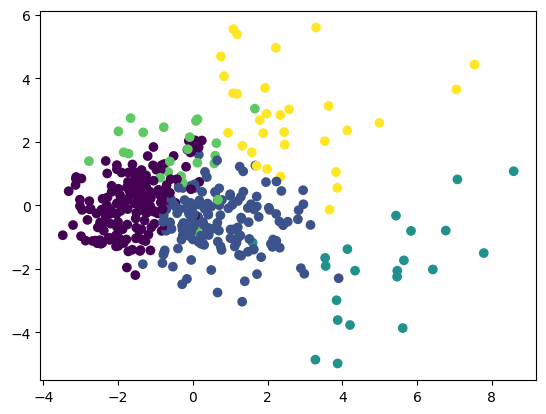

In [74]:
pca=PCA(n_components=2)
X_pca=pca.fit_transform(xscaled)
plt.scatter(X_pca[:,0],X_pca[:,1], c=labels)
plt.show()

The technique of clustering can also be observed by calculating for the silhouette score of this model.

In [90]:
kmscore=silhouette_score(xscaled, labels)
print(kmscore)

0.12636146303387596


Finally, the cluster size will be examine to view if clusters are balanced.

In [92]:
kmclustersize=pd.Series(labels).value_counts()
print(kmclustersize)

0    182
1    160
4     31
3     24
2     21
Name: count, dtype: int64


**Agglomerative Clustering**

After determining the appropriate k for KMeans, we will repeat the evaluation process with agglomerative clustering to compare differences in performance and clustering.

In [76]:
agglomerative=AgglomerativeClustering(n_clusters=5)
agglabels=agglomerative.fit_predict(xscaled)

In [77]:
clusterencode=encode.copy()
clusterencode['cluster']=agglabels
clusterencode.groupby('cluster').mean()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Stage,Status_CL,Status_D,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
cluster,,,,,,,,,,,,,,,,,,,,,
0,1735.531034,19758.055172,3.595172,354.900631,3.401586,108.407742,2665.290796,127.365048,123.682905,235.407913,...,3.324807,0.000000,0.758621,0.337931,0.255172,0.048276,0.820690,0.220690,0.227586,0.000000
1,2278.950739,17885.512315,1.300000,327.557674,3.637438,67.842428,1485.486756,109.234545,114.023373,268.749374,...,2.675116,0.000000,0.059113,0.364532,0.000000,0.000000,0.463054,0.118227,0.014778,0.000000
2,721.409091,21030.090909,7.918182,275.705986,2.927727,216.409091,1871.918182,146.566818,123.323017,184.909091,...,3.818182,0.000000,0.863636,0.409091,0.181818,0.681818,0.772727,0.727273,0.000000,0.863636
3,1580.125000,15235.708333,3.450000,366.065581,3.515000,118.870430,1557.663942,127.059920,131.038121,310.125000,...,3.208333,1.000000,0.000000,0.375000,0.125000,0.000000,0.708333,0.208333,0.125000,0.000000
4,1398.333333,17622.708333,12.670833,902.062940,3.397083,154.666667,2590.125000,179.670833,216.112589,301.458333,...,3.250000,0.041667,0.833333,0.541667,0.000000,0.083333,0.791667,0.541667,0.208333,0.041667


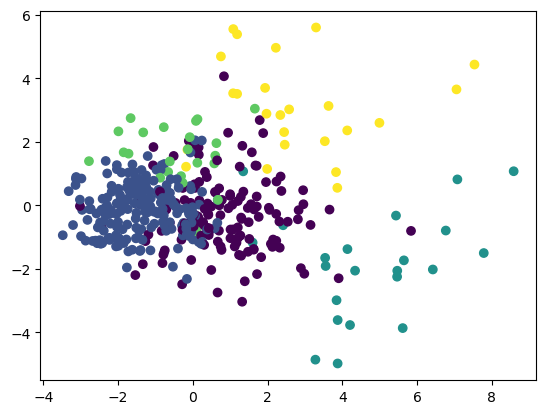

In [78]:
plt.figure()
plt.scatter(X_pca[:,0],X_pca[:,1],c=agglabels)
plt.show()

The silhouette score was also calculated for agglomerative clustering so that both models could be compared.

In [89]:
aggscore=silhouette_score(xscaled,agglabels)
print(aggscore)

0.13911091016435342


In [96]:
aggclustersize=pd.Series(agglabels).value_counts()
print(aggclustersize)

1    203
0    145
3     24
4     24
2     22
Name: count, dtype: int64


**Comparing the Models**

In [97]:
compare=pd.DataFrame({
    'model':['KMeans','agglomerative'],
    'silhouette score':[kmscore,aggscore],
    'cluster size':[list(kmclustersize),list(aggclustersize)]
})
compare

,model,silhouette score,cluster size
0,KMeans,0.126361,"[182, 160, 31, 24, 21]"
1,agglomerative,0.139111,"[203, 145, 24, 24, 22]"


**Summary:** Based on our assessment of model performance, both models performed similarly, with agglomerative clustering obtained a slightly higher silhouette score, which means it performed better at separating clusters. The observed cluster sizes are similar, which shows that models have the ability to observe the same groupings within the dataset. The PCA visuals also show that both models were able to plot the same distribution, with an observable dense group surrounded by smaller clusters of more extreme records. 

## Interpreting the clusters

Let's compare clusters from both models to examine any identified relationships between features. The feature values for both the KMeans and the Agglomerative Clustering model will be standardized in order for features to be compared fairly and allow for an easier interpretation.

In [124]:
kmscaled=pd.DataFrame(
    StandardScaler().fit_transform(km[factors]),
    columns=factors,
    index=km.index
)
aggscaled=pd.DataFrame(
    StandardScaler().fit_transform(agg[factors]),
    columns=factors,
    index=agg.index
)

**KMeans**

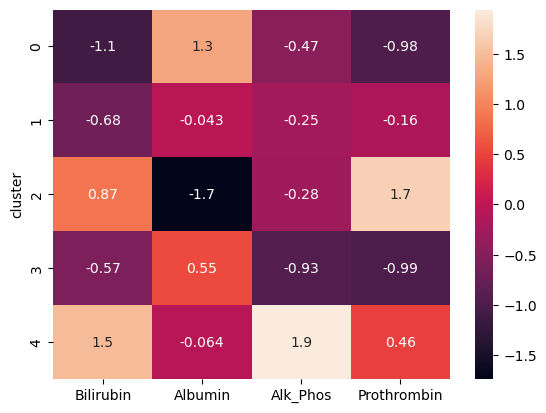

In [125]:
plt.figure()
sns.heatmap(kmscaled, annot=True)
plt.show()

**Agglomerative Clustering**

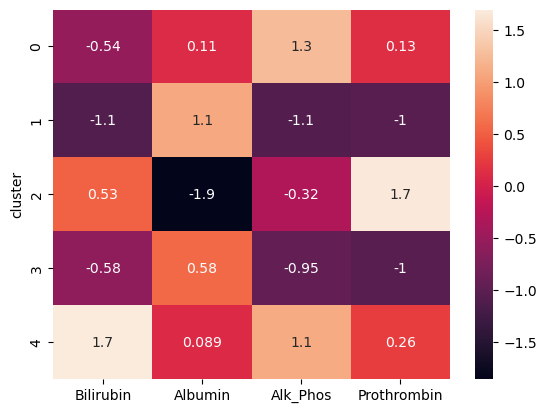

In [126]:
plt.figure()
sns.heatmap(aggscaled, annot=True)
plt.show()

**Summary**: The clusters were compared for both KMeans and Agglomerative, which yielded very similar patterns. Cluster 1 characterizes a healthier profile of patients among both models, as shown by mostly negative values. The second cluster shows elevated Prothrombin and Bilirubin levels while Albumin is much lower than other clusters. Cluster 3 shows both a decrease in Prothrombin and Alkaline Phosphate, while Albumin is slightly positive. Cluster 4 characterizes the severe cases, where Bilirubin and Alkaline Phosphate are highest, with Prothrombin also being slightly elevated. <br>
Through both of these models, a stable pattern can be shown about underlying patterns in the data by separating the high risk and low risk profiles. Looking at Agglomertive Clustering, it was slightly better at capturing a better distinction between low risk and high risk profiles, which was observed earlier when calculating the silhouette score.

## Discussion and Conclusion

Based on our findings, both KMeans and Agglomerative Clustering were able to reveal similar underlying patterns within the dataset concerning Liver cirrhosis outcome data. EDA demonstrated the presence of right-skewed features such as Bilirubin and Alkaline Phosphatase, which were hypothesized as being important features for this analysis. When comparing between both models, the cluster size and feature means were similar, with Agglomerative Clustering slightly outranking KMeans for the silhouette score. This means that Agglomerative Clustering achieved better separation, but overall analysis still revealed similar results for both models. The interpretation of the clusters showed that patients with more severe disease patterns had elevated Bilirubin and Prothrombin levels, while also demonstrating lower Albumin levels than healthier patients. Some limitations that were found in this project was that the silhouette score was relatively low, which may reveal that the amount of separation between groups is limited. EDA also revealed that many outliers in the data were present, which may have influenced cluster formation and overall bias for model performance. In the future, work can be improved for this project by testing out additional clustering methods such as Gaussian models in order to examine data structures of a higher complexity. 